In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import_path = "/Users/michalmacbookpro/Downloads/titanic/"
train = pd.read_csv(import_path + "train.csv",index_col="PassengerId")
test = pd.read_csv(import_path + "test.csv",index_col="PassengerId")
submision = pd.read_csv(import_path + "gender_submission.csv")

In [3]:
train[["man","woman"]] = pd.get_dummies(train["Sex"])
train[["1","2","3"]] = pd.get_dummies(train["Pclass"])
train[["c","q","s"]] = pd.get_dummies(train["Embarked"])

def cabinizer(df):
    df["Cabin_L"] = df["Cabin"].str.extract(r"(^\D{0,1})")
    df["Cabin_L"].fillna("U",inplace=True)
    df["Cabin_L"] = df["Cabin_L"].map({"A":"ABC","B":"ABC","C":"ABC","D":"DE","E":"DE","F":"FG","G":"FG","T":"ABC","U":"U"})
    return df

def familiazer(df):
    df["Family"] = df["SibSp"] + df["Parch"]
    df["Family"] = df["Family"]
    return df


def aloniazer(df):
    df["Alone"] = 0
    df.loc[df["Family"]==0,"Alone"] = 1
    return df

cabinizer(train)
familiazer(train)
aloniazer(train)

train[["ABC","DE","FG","U"]] = pd.get_dummies(train["Cabin_L"])

to_drop = ["Pclass","Name","Sex","SibSp","Parch","Ticket","Cabin","Embarked","Cabin_L","Family","2","q","FG","woman"]
train.drop(to_drop,inplace=True,axis=1)

train["Age"].fillna(np.mean(train["Fare"]),inplace=True)
mean_fare = np.mean(train["Fare"])
std_fare = np.std(train["Fare"])
#mean_age = np.mean(train["Age"])
#std_age = np.std(train["Age"])

#train["Age"] = (train["Age"] - mean_age)/std_age

train["Fare"] = (train["Fare"] - mean_fare)/std_fare
train.sample(15)

,Survived,Age,Fare,man,1,3,c,s,Alone,ABC,DE,U
PassengerId,,,,,,,,,,,,
659,0,23.000000,-0.386671,0,0,0,0,1,1,0,0,1
603,0,32.204208,0.205289,0,1,0,0,1,1,0,0,1
286,0,33.000000,-0.474005,0,0,1,1,0,1,0,0,1
334,0,16.000000,-0.285997,0,0,1,0,1,0,0,0,1
210,1,40.000000,-0.024246,0,1,0,1,0,1,1,0,0
560,1,36.000000,-0.298078,1,0,1,0,1,0,0,0,1
142,1,22.000000,-0.492378,1,0,1,0,1,1,0,0,1
723,0,34.000000,-0.386671,0,0,0,0,1,1,0,0,1
838,0,32.204208,-0.486337,0,0,1,0,1,1,0,0,1


In [4]:
y = train["Survived"]
X = train.drop(["Survived"],axis=1)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
#resample nie je aplikovatelne, je to celkom vyrovnane, potom ako posledne
#bagging
from sklearn.ensemble import BaggingClassifier
#halvin random search
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LogisticRegression

/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()

In [8]:
dtc2 = DecisionTreeClassifier(criterion="entropy",max_depth=8)
ada = AdaBoostClassifier(base_estimator=dtc2,learning_rate=0.2,n_estimators=200)
#
ada.fit(X_train,y_train)
y_pred_0 = ada.predict(X_test)
print(accuracy_score(y_pred_0, y_test))

0.7835820895522388


In [9]:
dtc2 = DecisionTreeClassifier(criterion="gini",max_depth=8)
bag = BaggingClassifier(base_estimator=dtc2,n_estimators=150,n_jobs=-1)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
print(accuracy_score(y_pred_bag,y_test))

0.7985074626865671


In [10]:
param = [{
    "criterion": ['gini', 'entropy'],
    "n_estimators":[200,300,400,500],
    'max_depth': range(4, 20, 2),
    'max_leaf_nodes': range(4, 28, 2),
}]
#
gs_rt = GridSearchCV(rfc, param, cv = 5, n_jobs = -1, verbose = 1)
gs_rt.fit(X_train, y_train)
y_pred_rfc = gs_rt.predict(X_test)
print(gs_rt.best_estimator_)
print(accuracy_score(y_pred_rfc,y_test))
rt_rs_best = gs_rt.best_estimator_

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
RandomForestClassifier(max_depth=14, max_leaf_nodes=14, n_estimators=300)
0.8022388059701493


In [11]:
print(accuracy_score(y_pred_rfc,y_test))

0.8022388059701493


In [12]:
param = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 20, 2),
        'max_leaf_nodes': range(4, 28, 2),
    }
]
#
gs_dt = GridSearchCV(dtc, param, cv = 5, n_jobs = -1, verbose = 1,scoring="accuracy")
gs_dt.fit(X_train, y_train)
y_pred = gs_dt.predict(X_test)
print(accuracy_score(y_pred,y_test))
dt_gs_best = gs_dt.best_estimator_
print(gs_dt.best_estimator_)
#print(accuracy_score(y_pred,y_test))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
0.7873134328358209
DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=14)


In [13]:
from sklearn.svm import SVC

svc = SVC()

param = [
    {
        'kernel': ['rbf'], 
        'C': [0.1, 0.3, 1, 2, 3, 4], 
        'gamma': [0.1,0.2,0.3]
    }, 
]

svc = SVC(probability = True)
rs_svc = GridSearchCV(svc, param, cv =5, n_jobs = -1, verbose = 1)
rs_svc.fit(X_train, y_train)
y_pred = rs_svc.predict(X_test)
print(accuracy_score(y_pred,y_test))
svc_best = rs_svc.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0.753731343283582


In [14]:
param = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 20, 2),
        'max_leaf_nodes': range(4, 28, 2),
    }
]
#
hs = HalvingRandomSearchCV(dtc,
            param_distributions=param,
            n_candidates='exhaust',
            resource='n_samples',
            factor=1.3,
            random_state=1,
            n_jobs=-1)
#
hs.fit(X_train,y_train)
y_pred_hs = hs.predict(X_test)
print(accuracy_score(y_pred_hs,y_test))

0.7835820895522388


In [15]:
param = [
    {'n_estimators': range(8, 28, 4), 
     'max_depth': range(24, 48, 4),
     'max_leaf_nodes': range(20, 48, 4),
    }
]
#
et = ExtraTreesClassifier()
gs_et = RandomizedSearchCV(et, param, cv = 5, n_jobs = -1, verbose = 1)
gs_et.fit(X_train, y_train)
y_pred = gs_et.predict(X_test)
print(accuracy_score(y_pred,y_test))
print(gs_et.best_estimator_)
extra_best = gs_et.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7873134328358209
ExtraTreesClassifier(max_depth=36, max_leaf_nodes=40, n_estimators=8)


In [16]:
param_grid={
    'max_depth': range(2, 10, 2),
    'n_estimators': range(26, 46, 2),
    'learning_rate': [0.2, 0.1, 0.03, 0.01]
}
#
xg = XGBClassifier(eval_metric='logloss', n_jobs = -1, use_label_encoder = False)
gs_xg = RandomizedSearchCV(xg, param_grid, cv = 5, n_jobs = -1, verbose = 1)
gs_xg.fit(X_train, y_train)
y_pred = gs_xg.predict(X_test)
print(accuracy_score(y_pred,y_test))
xboo_best = gs_xg.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inste

0.8097014925373134


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [17]:
lr = LogisticRegression()

lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
print(accuracy_score(y_pred_lr,y_test))

0.7947761194029851


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
voting_clf = VotingClassifier(estimators=[
    ("rand_for",rt_rs_best),
    ("dec_tree",dt_gs_best),
    ("svc",svc_best),
    ("extree",extra_best),
    ("xgb",xboo_best),
    ("ada",ada),
    ("bag",bag)],
    voting = 'soft', n_jobs = -1, verbose = 1)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(accuracy_score(y_pred,y_test))

[Voting] ................. (2 of 7) Processing dec_tree, total=   0.0s
[Voting] ................... (4 of 7) Processing extree, total=   0.0s
[Voting] ...................... (3 of 7) Processing svc, total=   0.1s


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[Voting] ................. (1 of 7) Processing rand_for, total=   0.2s
[Voting] ...................... (5 of 7) Processing xgb, total=   0.2s
[Voting] ...................... (7 of 7) Processing bag, total=   0.2s
[Voting] ...................... (6 of 7) Processing ada, total=   0.3s
0.8097014925373134


In [20]:
test = pd.read_csv(import_path + "test.csv",index_col="PassengerId")

test[["man","woman"]] = pd.get_dummies(test["Sex"])
test[["1","2","3"]] = pd.get_dummies(test["Pclass"])
test[["c","q","s"]] = pd.get_dummies(test["Embarked"])

def cabinizer(df):
    df["Cabin_L"] = df["Cabin"].str.extract(r"(^\D{0,1})")
    df["Cabin_L"].fillna("U",inplace=True)
    df["Cabin_L"] = df["Cabin_L"].map({"A":"ABC","B":"ABC","C":"ABC","D":"DE","E":"DE","F":"FG","G":"FG","T":"ABC","U":"U"})
    return df

def familiazer(df):
    df["Family"] = df["SibSp"] + df["Parch"]
    df["Family"] = df["Family"]
    return df


def aloniazer(df):
    df["Alone"] = 0
    df.loc[df["Family"]==0,"Alone"] = 1
    return df

cabinizer(test)
familiazer(test)
aloniazer(test)

test[["ABC","DE","FG","U"]] = pd.get_dummies(test["Cabin_L"])

to_drop = ["Pclass","Name","Sex","SibSp","Parch","Ticket","Cabin","Embarked","Cabin_L","Family","2","q","FG","woman"]
test.drop(to_drop,inplace=True,axis=1)

test["Age"].fillna(np.mean(test["Fare"]),inplace=True)
test["Fare"].fillna(np.mean(test["Fare"]),inplace=True)
mean_fare = np.mean(test["Fare"])
std_fare = np.std(test["Fare"])
#mean_age = np.mean(test["Age"])
#std_age = np.std(test["Age"])

#test["Age"] = (test["Age"] - mean_age)/std_age

test["Fare"] = (test["Fare"] - mean_fare)/std_fare
test.sample(15)


submision["Survived"] = voting_clf.predict(test).astype("int")
submision.to_csv('submission.csv', index = False)

In [21]:
from sklearn.decomposition import PCA

In [36]:
pca = PCA(n_components=2)

In [37]:
pca_D = pca.fit_transform(X_train)

In [41]:
X_test_pca = pca.transform(X_test)

In [38]:
pca_D

array([[-11.43688828,   1.03165775],
       [  1.73829624,  -0.82220275],
       [  1.73640528,  -0.5673935 ],
       ...,
       [ 17.52275452,  -0.27706133],
       [ 16.56413552,   0.33752119],
       [-11.44337157,   0.7174767 ]])

<AxesSubplot:>

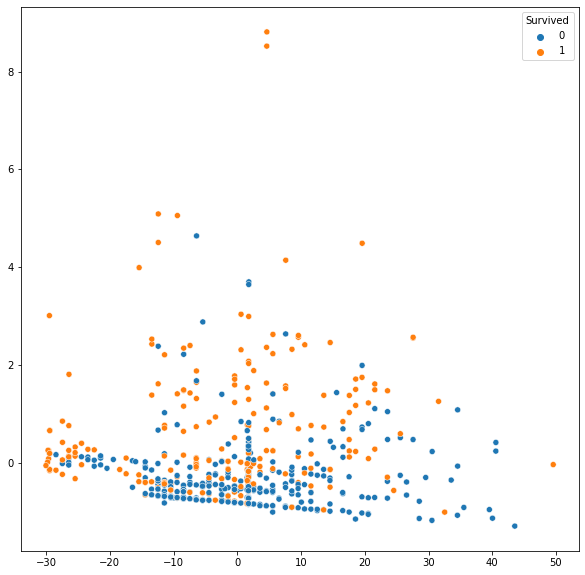

In [40]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=pca_D[:,0],y=pca_D[:,1],hue=y_train)

In [42]:
lr.fit(pca_D,y_train)
y_pred_pca = lr.predict(X_test_pca)
print(accuracy_score(y_pred_pca,y_test))

0.6604477611940298


In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)